In [1]:
#import modules
import argparse
import os
import random
import numpy as np
import dataset
import modules2
import train


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from glob import glob

from PIL import Image
import dataset
import modules
import utils
import predict

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)
print(torch.cuda.is_available())

# Hyperparameters
LEARNING_RATE = 0.0001
ROOTLOC = "\ISIC"
TRAINDATA = "ISIC\ISIC-2017_Training_Data\ISIC-2017_Training_Data"
TESTDATA = "ISIC\ISIC-2017_Test_v2_Data\ISIC-2017_Test_v2_Data"
VALIDDATA = "ISIC\ISIC-2017_Validation_Data\ISIC-2017_Validation_Data"
TRAINTRUTH = "ISIC\ISIC-2017_Training_Part1_GroundTruth\ISIC-2017_Training_Part1_GroundTruth"
TESTTRUTH = "ISIC\ISIC-2017_Test_v2_Part1_GroundTruth\ISIC-2017_Test_v2_Part1_GroundTruth"
VALIDTRUTH = "ISIC\ISIC-2017_Validation_Part1_GroundTruth\ISIC-2017_Validation_Part1_GroundTruth"

NUM_EPOCHS = 1
BATCH_SIZE = 1
WORKERS = 4


Device: cuda:0
True


In [2]:

train_dataset = dataset.CustomDataset(image_dir = TRAINDATA,
                                mask_dir=TRAINTRUTH,
                                transform=transforms.Compose([
                                transforms.ToTensor()]))
'''
transforms.Compose([
transforms.ToTensor(),
transforms.RandomRotation(30),
transforms.RandomResizedCrop(224),
transforms.RandomHorizontalFlip()])
'''


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True)

valid_dataset = dataset.CustomDataset(image_dir = VALIDDATA,
                                mask_dir=VALIDTRUTH,
                                transform=transforms.Compose([
                                    transforms.ToTensor()]))


'''
transforms.RandomRotation(30),
transforms.RandomResizedCrop(224),
transforms.RandomHorizontalFlip()
'''
                                
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True)
'''

test_dataset = dataset.CustomDataset(image_dir = TESTDATA,
                                     mask_dir=TESTTRUTH,
                                    transform=transforms.Compose([
                                    transforms.ToTensor()]))
'''
'''
transforms.Compose([
transforms.ToTensor(),
transforms.RandomRotation(30),
transforms.RandomResizedCrop(224),
transforms.RandomHorizontalFlip()])
'''
'''
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True)
'''


print(enumerate(train_dataloader))
print(len(train_dataloader))
#print(len(test_dataloader))
print(len(train_dataset))
#print(len(test_dataset))






2000
2000


image: (3, 256, 256)
mask: (1, 256, 256)


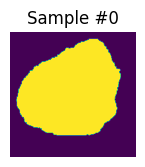

image: (3, 256, 256)
mask: (1, 256, 256)


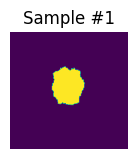

image: (3, 256, 256)
mask: (1, 256, 256)


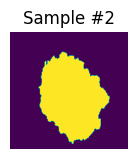

image: (3, 256, 256)
mask: (1, 256, 256)


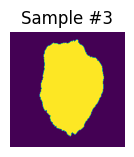

In [3]:

for i, sample in enumerate(train_dataset):
    #print(sample)
    image = sample['image']
    mask = sample['mask']

    #print(i, sample['image'].shape, sample['mask'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    #image = image.numpy()
    image = np.array(image)
    mask = np.array(mask)
    print("image:", image.shape)
    print("mask:", mask.shape)
    #print(type(image))
    image = np.transpose(image, (1, 2, 0))
    mask = np.transpose(mask, (1, 2, 0))

    plt.imshow(image)
    plt.imshow(mask)

    plt.show()
    if i == 3:
        plt.show()
        break

TRAIN 

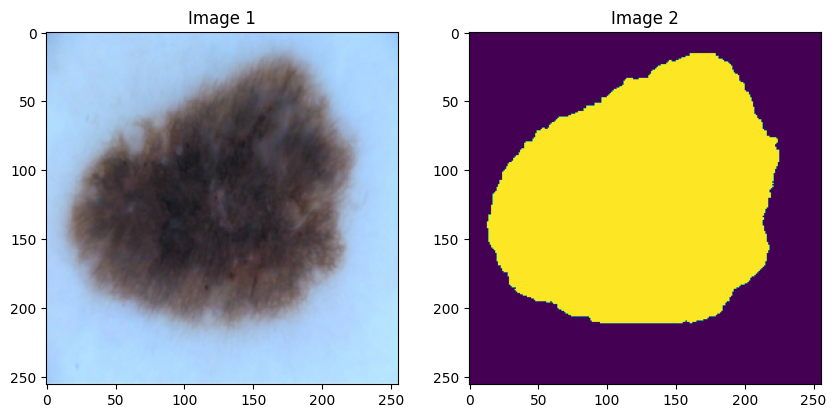

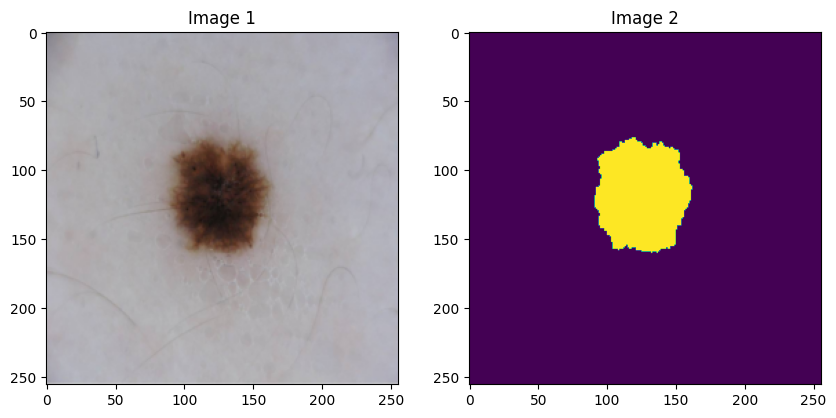

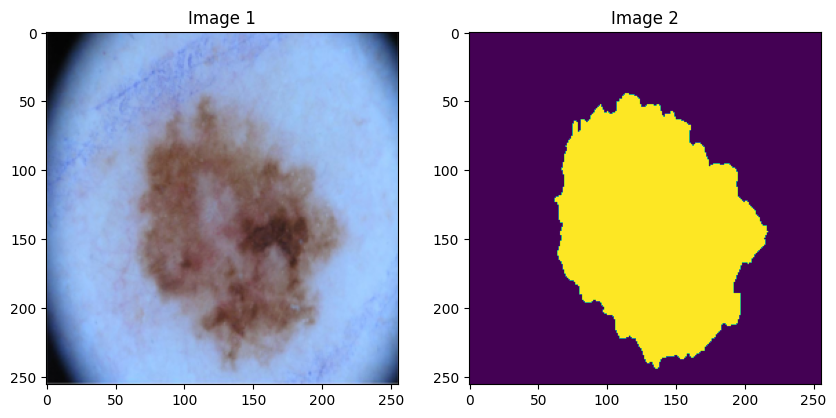

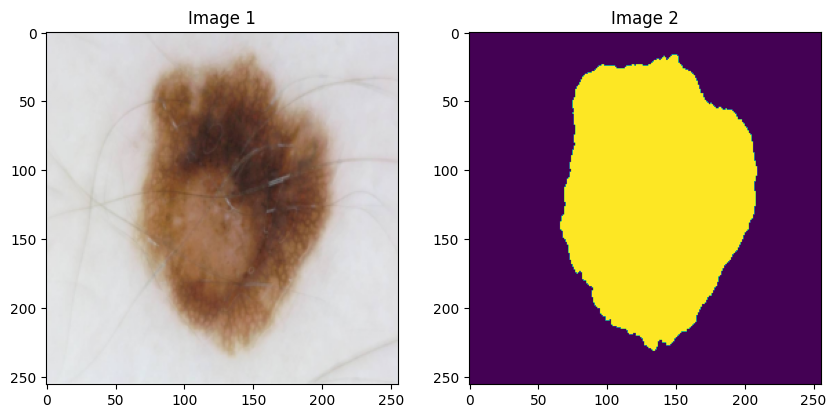

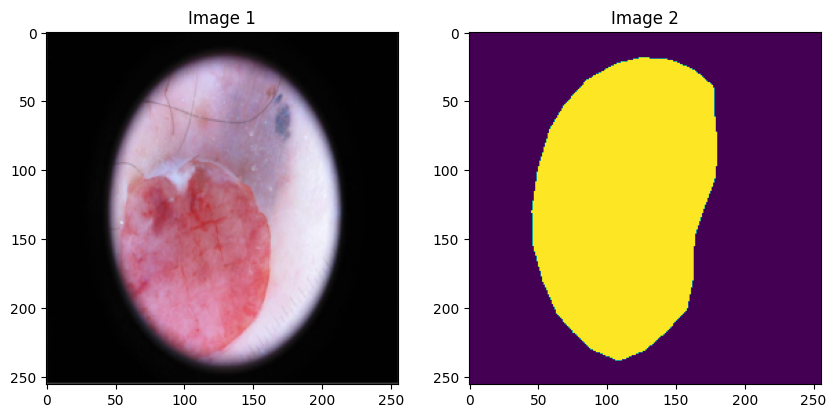

In [4]:

for i, sample in enumerate(train_dataset):
    #print(sample)
    image = sample['image']
    mask = sample['mask']
    # Load your two images

    image = np.array(image)
    mask = np.array(mask)
    #print("image:", image.shape)
    #print(type(image))
    image = np.transpose(image, (1, 2, 0))
    mask = np.transpose(mask, (1, 2, 0))

    # Create a figure with two subplots
    plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

    # Plot the first image in the left subplot
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image 1')

    # Plot the second image in the right subplot
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Image 2')

    # Show the images
    plt.show()
    if i == 4:
        break
    

In [5]:
class diceLoss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [6]:
model = modules.UNet(3,1,[64,128,256,512]) 
model = model.to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
criterion2 = diceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, 
                            momentum = 0.9, weight_decay = 5e-4)

total_steps = len(train_dataloader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr = LEARNING_RATE, 
                               steps_per_epoch = total_steps, epochs = NUM_EPOCHS)
print(total_steps)

model.train()
print("> Training") 
print(enumerate(train_dataloader))
print(train_dataloader)

2000
> Training


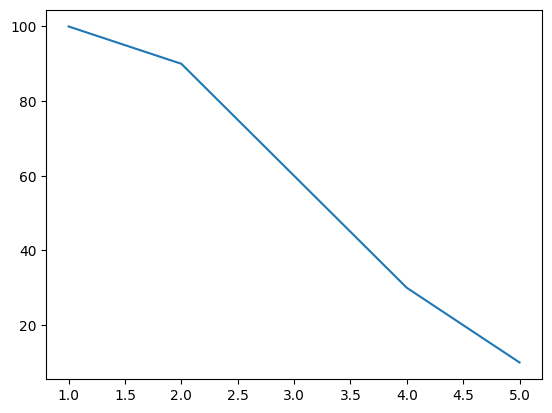

In [7]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

my_plot([1, 2, 3, 4, 5], [100, 90, 60, 30, 10])


EPOCH: 0
Epoch [1/1], Step [100/2000], Loss: 0.82066
Epoch [1/1], Step [200/2000], Loss: 0.98263
Epoch [1/1], Step [300/2000], Loss: 0.78951
Epoch [1/1], Step [400/2000], Loss: 0.65605
Epoch [1/1], Step [500/2000], Loss: 0.82850
Epoch [1/1], Step [600/2000], Loss: 0.97589
Epoch [1/1], Step [700/2000], Loss: 0.70511
Epoch [1/1], Step [800/2000], Loss: 0.92076
Epoch [1/1], Step [900/2000], Loss: 0.83297
Epoch [1/1], Step [1000/2000], Loss: 0.84831
Epoch [1/1], Step [1100/2000], Loss: 0.69633
Epoch [1/1], Step [1200/2000], Loss: 0.97356
Epoch [1/1], Step [1300/2000], Loss: 0.66239
Epoch [1/1], Step [1400/2000], Loss: 0.81498
Epoch [1/1], Step [1500/2000], Loss: 0.99064
Epoch [1/1], Step [1600/2000], Loss: 0.72663
Epoch [1/1], Step [1700/2000], Loss: 0.83075
Epoch [1/1], Step [1800/2000], Loss: 0.85694
Epoch [1/1], Step [1900/2000], Loss: 0.97062
Epoch [1/1], Step [2000/2000], Loss: 0.93323
Training took  secs
> Testing


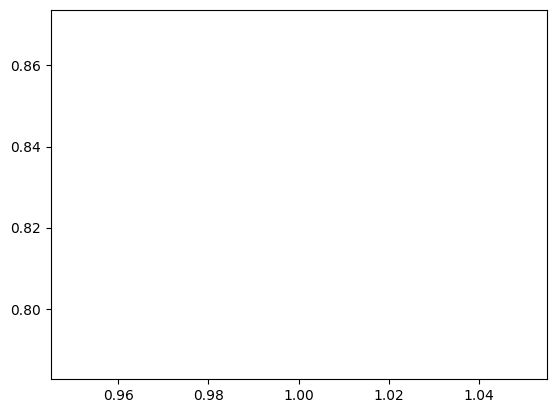

In [8]:
loss_vals=  []
for epoch in range(NUM_EPOCHS):
    epoch_loss= []
    print("EPOCH:",epoch)
    for i, batch in enumerate(train_dataloader):
        images = batch['image']
        masks = batch['mask']
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)
        outputs = torch.round(outputs)
        masks = torch.round(masks)
        loss = criterion2(outputs, masks)
        epoch_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{total_steps}], Loss: {loss.item():.5f}')
            #utils.save_predictions_as_imgs(valid_dataloader,model)
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    my_plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS).astype(int), loss_vals)
    utils.save_predictions_as_imgs(valid_dataloader,model)
FILE = "model.pth"
torch.save(model.state_dict(), FILE)

loaded_model = modules.UNet(3,1,[64,128,256,512]) 
loaded_model.load_state_dict(torch.load(FILE))
loaded_model.eval()


print("Training took " +  " secs")
print("> Testing")

    


In [9]:


'''
FILE = "model.pth"
loaded_model = modules.UNet(3,1,[64,128,256,512]) 
loaded_model.load_state_dict(torch.load(FILE))
loaded_model.to(DEVICE)
loaded_model.eval()
utils.save_predictions_as_imgs(valid_dataloader,loaded_model)
print("HELP")
utils.check_accuracy(valid_dataloader,loaded_model)
'''

HELP
Got 1707471/9830400 with acc 17.37
Dice score: 0.251137375831604
